# Laboratorio 7
### Security Data Science
- Christian Pérez
- Andrei Portales

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from art.estimators.classification import KerasClassifier #No soporta TF 2
from art.attacks.evasion import FastGradientMethod
from art.utils import load_dataset

# Disabling eager execution from TF 2
tf.compat.v1.disable_eager_execution()

c:\Users\Christian\Documents\python_env\data_sciece_env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [4]:
vulnerable_model = tf.keras.models.load_model("modelo")

In [8]:
data_dir = 'malimg_paper_dataset_imgs2'

In [10]:
familias_malware = os.listdir(data_dir)

In [ ]:
for familia in familias_malware:
    print(f'{familia}: {len(os.listdir(os.path.join(data_dir, familia)))}')

In [11]:
img_height, img_width = 64, 64
batch_size = 128
epochs = 80

In [12]:
datagen = ImageDataGenerator(rescale=1./255)
data_generator = datagen.flow_from_directory(data_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical', shuffle=True)
class_indices = data_generator.class_indices
num_classes = len(class_indices)

Found 5763 images belonging to 25 classes.


In [13]:
X, y = data_generator.next()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Ataque de evasión

In [15]:
clasificador = KerasClassifier(
    model=vulnerable_model,
    clip_values=(100, 1000))

In [16]:
attack_fgsm = FastGradientMethod(
    estimator=clasificador, 
    eps=0.3
)

In [17]:
test_images_adv = attack_fgsm.generate(x=X_test)

c:\Users\Christian\Documents\python_env\data_sciece_env\lib\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


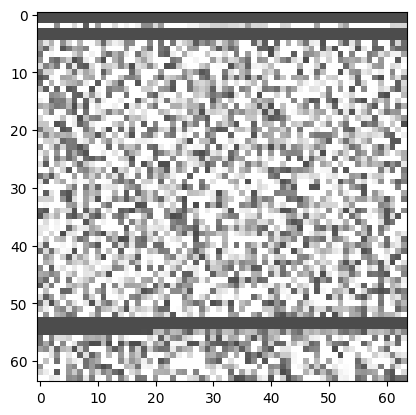

In [18]:
plt.imshow(X=test_images_adv[0])

In [19]:
# Evaluating the model on clean images
score_clean = vulnerable_model.evaluate(
    x=X_test, 
    y=y_test
    )

# Evaluating the model on adversarial images
score_adv = vulnerable_model.evaluate(
    x=test_images_adv, 
    y=y_test
    )

# Comparing test losses
print(f"Clean test set loss: {score_clean[0]:.2f} " 
      f"vs adversarial set test loss: {score_adv[0]:.2f}")

# Comparing test accuracies
print(f"Clean test set accuracy: {score_clean[1]:.2f} " 
      f"vs adversarial test set accuracy: {score_adv[1]:.2f}")

Clean test set loss: 3.08 vs adversarial set test loss: 8.98
Clean test set accuracy: 0.69 vs adversarial test set accuracy: 0.08


c:\Users\Christian\Documents\python_env\data_sciece_env\lib\site-packages\keras\engine\training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

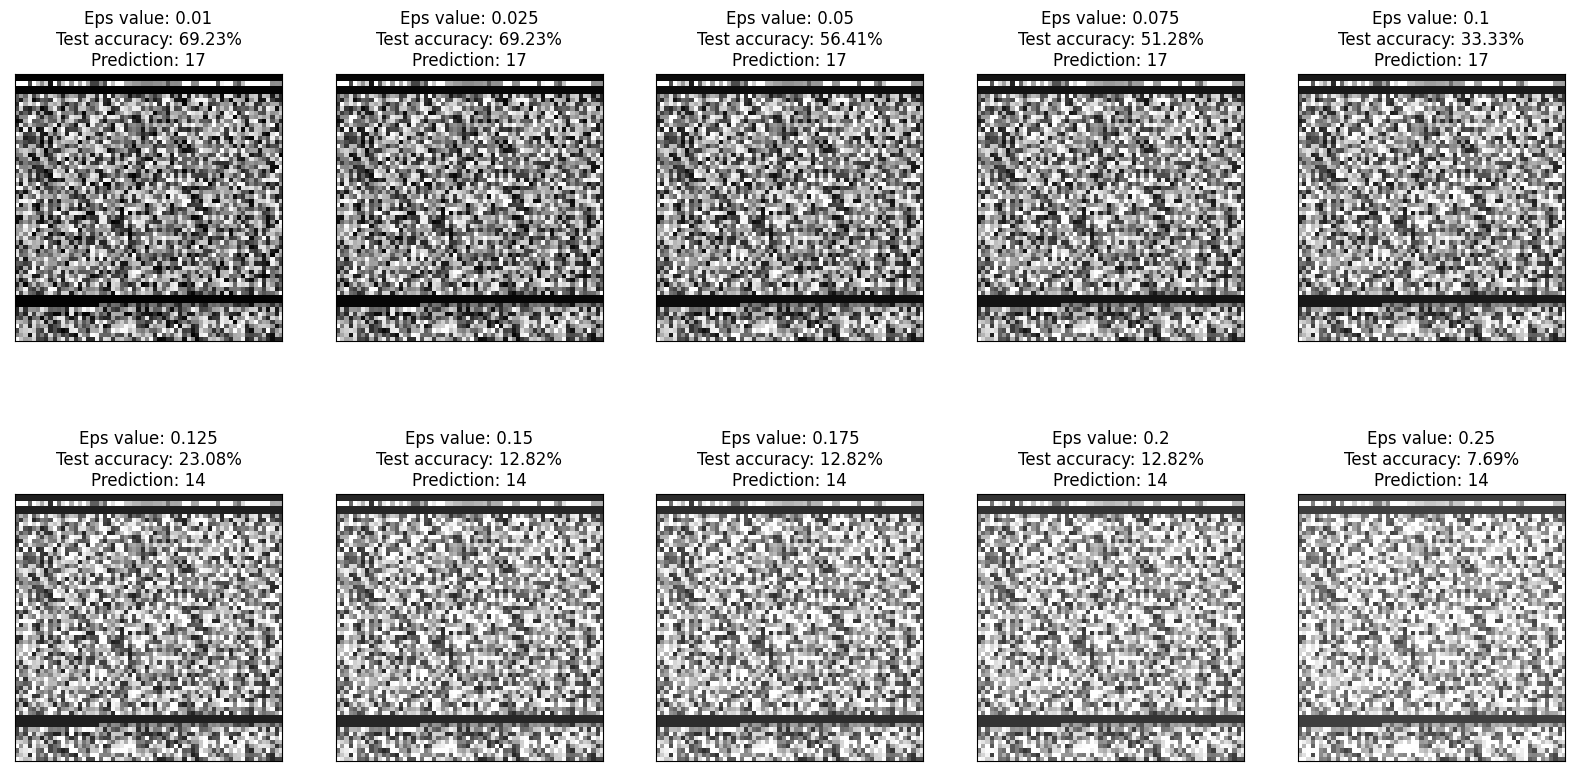

In [20]:
# Setting the number of rows and columns for the figure
nrows, ncols = 2, 5

# Generating subplots
fig, axes = plt.subplots(
    nrows=nrows, 
    ncols=ncols, 
    figsize=(20, 10)
    )

# Defining a range of eps values to try
eps_to_try = [0.01, 0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2, 0.25]

# Defining a counting variable to traverse eps_to_try
counter = 0

# Iterating over rows and cols
for i in range(nrows):
    for j in range(ncols):    
        # Creating an attack object for the current value of eps    
        attack_fgsm = FastGradientMethod(
            estimator=clasificador, 
            eps=eps_to_try[counter]
            )

        # Generating adversarial images
        test_images_adv = attack_fgsm.generate(x=X_test)

        # Showing the first adversarial image
        axes[i, j].imshow(X=test_images_adv[0])

        # Disabling x and y ticks
        axes[i, j].set_xticks(ticks=[])
        axes[i, j].set_yticks(ticks=[])

        # Evaluating model performance on adversarial samples and retrieving test accuracy
        test_score = clasificador._model.evaluate(
            x=test_images_adv, 
            y=y_test,
            )[1]

        # Getting prediction for the image that we displayed
        prediction = np.argmax(vulnerable_model.predict(
            x=np.expand_dims(a=test_images_adv[0], 
            axis=0)
            ))    

        # Showing the current eps value, test accuracy, and prediction
        axes[i, j].set_title(
            label=f"Eps value: {eps_to_try[counter]}\n"
            f"Test accuracy: {test_score * 100:.2f}%\n"
            f"Prediction: {prediction}"
            )

        # Incrementing counter
        counter += 1

# Showing the plot
plt.show()